### Dataset inconsistencies

In [26]:
import json
with open('../data/train_separate_questions_full.json') as f:
    train_dict = json.load(f)
with open('../data/CUADv1.json') as f:
    test_dict = json.load(f)


In [63]:
known_inconsistent = set(['VARIABLESEPARATEACCOUNT_04_30_2014-EX-13.C-UNCONDITIONAL CAPITAL MAINTENANCE AGREEMENT','PACIFICSYSTEMSCONTROLTECHNOLOGYINC_08_24_2000-EX-10.53-SPONSORSHIP AGREEMENT'])

In [64]:
from collections import defaultdict
contract_count = defaultdict(int)
for contract in train_dict['data']:
    if contract['title'] in known_inconsistent:
        print(contract['title'])
        print(len([(x['question'].split('"')[1].split('"')[0],x['answers'][0]["answer_start"]) for x in contract['paragraphs'][0]['qas'] if x['answers']]))
        print([(x['question'].split('"')[1].split('"')[0],x['answers'][0]["answer_start"]) for x in contract['paragraphs'][0]['qas'] if x['answers']])
    

VARIABLESEPARATEACCOUNT_04_30_2014-EX-13.C-UNCONDITIONAL CAPITAL MAINTENANCE AGREEMENT
14
[('Document Name', 175), ('Parties', 336), ('Parties', 449), ('Parties', 438), ('Parties', 481), ('Agreement Date', 302), ('Effective Date', 302), ('Expiration Date', 7938), ('Notice Period To Terminate Renewal', 8377), ('Notice Period To Terminate Renewal', 8045), ('Governing Law', 13131), ('Minimum Commitment', 15110), ('Minimum Commitment', 1280), ('Minimum Commitment', 3516)]
PACIFICSYSTEMSCONTROLTECHNOLOGYINC_08_24_2000-EX-10.53-SPONSORSHIP AGREEMENT
9
[('Document Name', 33), ('Parties', 4033), ('Parties', 541), ('Parties', 107), ('Parties', 334), ('Parties', 139), ('Agreement Date', 468), ('Governing Law', 3103), ('Anti-Assignment', 2237)]


In [65]:
for contract in test_dict['data']:
    if contract['title'] in known_inconsistent:
        print(contract['title'])
        print(len([(x['question'].split('"')[1].split('"')[0],x['answers'][0]["answer_start"]) for x in contract['paragraphs'][0]['qas'] if x['answers']]))
        print([(x['question'].split('"')[1].split('"')[0],x['answers'][0]["answer_start"]) for x in contract['paragraphs'][0]['qas'] if x['answers']])

VARIABLESEPARATEACCOUNT_04_30_2014-EX-13.C-UNCONDITIONAL CAPITAL MAINTENANCE AGREEMENT
8
[('Document Name', 175), ('Parties', 449), ('Agreement Date', 302), ('Effective Date', 302), ('Expiration Date', 7938), ('Notice Period To Terminate Renewal', 8045), ('Governing Law', 13131), ('Minimum Commitment', 3516)]
PACIFICSYSTEMSCONTROLTECHNOLOGYINC_08_24_2000-EX-10.53-SPONSORSHIP AGREEMENT
5
[('Document Name', 33), ('Parties', 107), ('Agreement Date', 468), ('Governing Law', 3103), ('Anti-Assignment', 2237)]


very clear that it's not the same marking across the datasets... We use the train_seperate_questions as this is the one their source code is refeering to 

## Improving the baseline
This notebooks is for extracting the non seperate train file from the CUAD dataset

In [2]:
import json
from copy import deepcopy

# load json file
with open('../data/train_separate_questions.json') as json_file:
    data = json.load(json_file)

In [3]:
contract_data = {}
for contract in data['data']:
    for para in contract['paragraphs']:
        qas = {}
        for qa in para['qas']:
            qa_title = '_'.join(qa['id'].split('_')[:-1])
            if qa_title not in qas:
                qas[qa_title] = deepcopy(qa)
                # change id
                qas[qa_title]['id'] = qa_title

            else:
                if qa['answers']:
                    qas[qa_title]['answers'].append(qa['answers'][0])
                    qas[qa_title]['is_impossible'] = qa['is_impossible']
        contract_data[contract['title']] = qas

In [4]:
from copy import deepcopy
data_2 = deepcopy(data)

In [5]:
for contract in data_2['data']:
    for para in contract['paragraphs']:
        para['qas']= list(contract_data[contract['title']].values())

Validate new dataset has same number of answers

In [6]:
ans_1_count =0
ans_1_set = set()
for contract in data['data']:
    for para in contract['paragraphs']:
        for qa in para['qas']:
            for ans in qa['answers']:
                ans_1_count += 1
                ans_1_set.add(ans['answer_start'])
            

In [7]:
ans_2_count =0
ans_2_set = set()
for contract in data_2['data']:
    for para in contract['paragraphs']:
        for qa in para['qas']:
            for ans in qa['answers']:
                ans_2_count += 1
                ans_2_set.add(ans['answer_start'])

In [9]:
# check if the two sets are the same
print(ans_1_count)
print(ans_2_count)
print(ans_1_set==ans_2_set)

11180
11180
True


In [10]:
# dump
with open('../data/train.json', 'w') as outfile:
    json.dump(data_2, outfile,indent=4, sort_keys=True)

## How many datapoints in the different dataset versions

In [1]:
import torch
import pandas as pd 
import numpy as np
import plotly.express as px


In [2]:
# Original dataset features
features_org = torch.load('../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_False_doc-stride_256_dataset-type_train_train-file-version_train_features')

In [7]:
from transformers.data.processors.squad import SquadFeatures
from collections import defaultdict
from tqdm import tqdm

data = []
for feature in tqdm(features_org):
    contract,question = feature.qas_id.split('__')
    question='_'.join(question.split('_')[:-1])
    
    data.append([contract, question, feature.is_impossible])

100%|██████████| 1134631/1134631 [00:25<00:00, 45261.79it/s] 


In [8]:
df = pd.DataFrame(data, columns=['contract', 'question','is_impossible'])

In [9]:
df.to_csv('old_features.csv')

In [10]:
df_g = df.groupby(['question','is_impossible']).count()
df_g = df_g.reset_index()
df_g.head(5)

,question,is_impossible,contract
0,Affiliate License-Licensee,False,111
1,Affiliate License-Licensee,True,21008
2,Affiliate License-Licensor,False,62
3,Affiliate License-Licensor,True,19992
4,Agreement Date,False,430


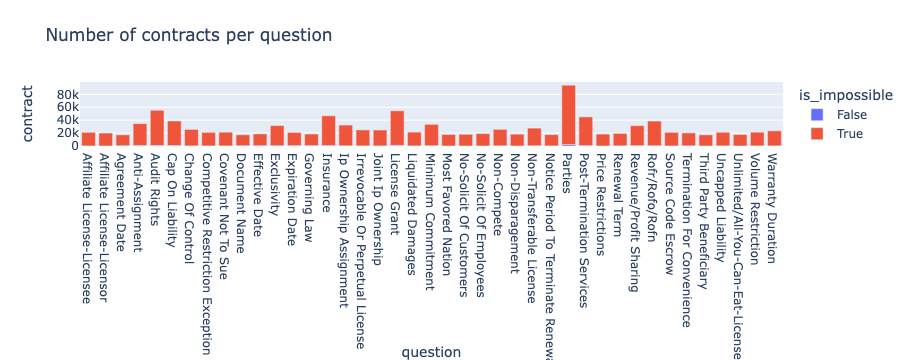

In [11]:
px.bar(df_g, x='question', y='contract', color='is_impossible', title='Number of contracts per question')

In [12]:
# New dataset features
features_new = torch.load('../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_False_doc-stride_256_dataset-type_train_train-file-version_train_non_sep_features')

In [13]:
data = []
for feature in tqdm(features_new):
    contract,question = feature.qas_id.split('__')
    
    data.append([contract, question, feature.is_impossible])

100%|██████████| 703959/703959 [00:01<00:00, 598109.80it/s]


In [14]:
df_2 = pd.DataFrame(data, columns=['contract', 'question','is_impossible'])
df_2.to_csv('new_features.csv')

In [15]:
df_g_2 = df_2.groupby(['question','is_impossible']).count()
df_g_2 = df_g_2.reset_index()
df_g_2.head(5)

,question,is_impossible,contract
0,Affiliate License-Licensee,False,99
1,Affiliate License-Licensee,True,17080
2,Affiliate License-Licensor,False,47
3,Affiliate License-Licensor,True,17127
4,Agreement Date,False,427


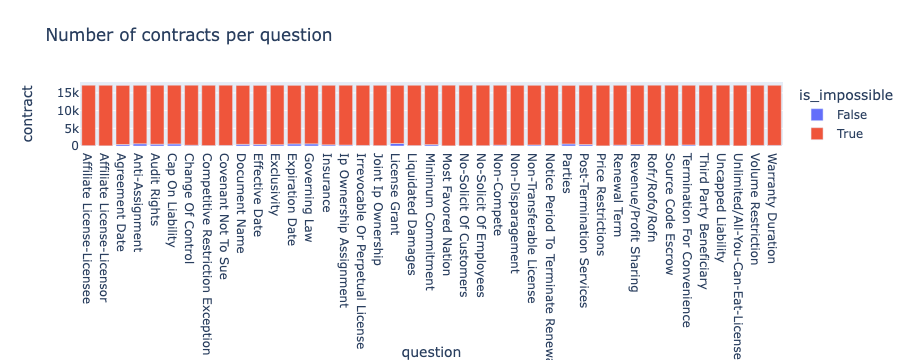

In [16]:
px.bar(df_g_2, x='question', y='contract', color='is_impossible', title='Number of contracts per question')

## Using the balanced dataset

In [17]:
import torch
import numpy as np


def get_dataset_pos_mask(dataset):
    """
    Returns a list, pos_mask, where pos_mask[i] indicates is True if the ith example in the dataset is positive
    (i.e. it contains some text that should be highlighted) and False otherwise.
    """
    pos_mask = []
    for i in range(len(dataset)):
        ex = dataset[i]
        start_pos = ex[3]
        end_pos = ex[4]
        is_positive = end_pos > start_pos
        pos_mask.append(is_positive)
    return pos_mask


def get_random_subset(dataset, keep_frac=1):
    """
    Takes a random subset of dataset, where a keep_frac fraction is kept.
    """
    keep_indices = [i for i in range(
        len(dataset)) if np.random.random() < keep_frac]
    subset_dataset = torch.utils.data.Subset(dataset, keep_indices)
    return subset_dataset


def get_balanced_dataset(dataset):
    """
    returns a new dataset, where positive and negative examples are approximately balanced
    """
    pos_mask = get_dataset_pos_mask(dataset)
    neg_mask = [~mask for mask in pos_mask]
    npos, nneg = np.sum(pos_mask), np.sum(neg_mask)

    # So that in expectation there will be npos negative examples (--> balanced)
    neg_keep_frac = npos / nneg
    neg_keep_mask = [mask and np.random.random(
    ) < neg_keep_frac for mask in neg_mask]

    # keep all positive examples and subset of negative examples
    keep_mask = [pos_mask[i] or neg_keep_mask[i] for i in range(len(pos_mask))]
    keep_indices = [i for i in range(len(keep_mask)) if keep_mask[i]]

    subset_dataset = torch.utils.data.Subset(dataset, keep_indices)
    return subset_dataset


Extract the data and do the same process

In [18]:
dataset_old=torch.load('../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_False_doc-stride_256_dataset-type_train_train-file-version_train_dataset')
print("Original dataset size:", len(dataset_old))
dataset_old_balanced = get_balanced_dataset(dataset_old)
print("Balanced dataset size:", len(dataset_old_balanced))

Original dataset size: 1134631
Balanced dataset size: 30787


In [24]:
features_org2=[]
for ele in tqdm(dataset_old_balanced):
    input_ids,attention_masks,token_type_ids,start_positions,end_positions,cls_index,p_mask,is_impossible,feature_index = ele
    features_org2.append(features_org[feature_index.item()])

100%|██████████| 30787/30787 [00:00<00:00, 43979.27it/s]


In [25]:
data = []
for feature in tqdm(features_org2):
    contract,question = feature.qas_id.split('__')
    question='_'.join(question.split('_')[:-1])
    
    data.append([contract, question, feature.is_impossible])

100%|██████████| 703959/703959 [00:01<00:00, 614731.49it/s]


In [29]:
df = pd.DataFrame(data, columns=['contract', 'question','is_impossible'])
df.to_csv('old_dataset_balanced_features.csv')

In [30]:
df_g = df.groupby(['question','is_impossible']).count()
df_g = df_g.reset_index()
df_g.head(5)

,question,is_impossible,contract
0,Affiliate License-Licensee,False,111
1,Affiliate License-Licensee,True,314
2,Affiliate License-Licensor,False,62
3,Affiliate License-Licensor,True,285
4,Agreement Date,False,429


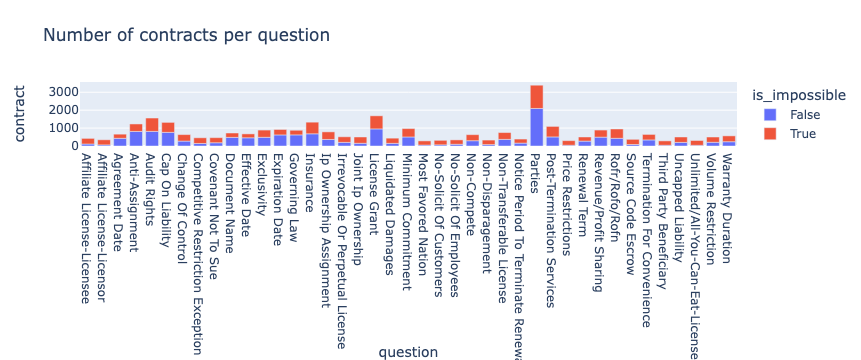

In [33]:
px.bar(df_g, x='question', y='contract', color='is_impossible', title='Number of contracts per question')

The new dataset

In [34]:
dataset_new=torch.load('../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_False_doc-stride_256_dataset-type_train_train-file-version_train_non_sep_dataset')
print("Original dataset size:", len(dataset_old))
dataset_new_balanced = get_balanced_dataset(dataset_new)
print("Balanced dataset size:", len(dataset_new_balanced))

Original dataset size: 1134631
Balanced dataset size: 21621


In [45]:
features_new2=[]
for ele in tqdm(dataset_new_balanced):
    input_ids,attention_masks,token_type_ids,start_positions,end_positions,cls_index,p_mask,is_impossible,feature_index = ele
    features_new2.append(features_new[feature_index.item()])

100%|██████████| 21621/21621 [00:00<00:00, 49998.40it/s]


In [52]:
data = []
for feature in tqdm(features_new2):
    contract,question = feature.qas_id.split('__')
    data.append([contract, question, feature.is_impossible])

100%|██████████| 21621/21621 [00:00<00:00, 431352.91it/s]


In [53]:
df = pd.DataFrame(data, columns=['contract', 'question','is_impossible'])
df.to_csv('old_new_balanced_features.csv')

In [54]:
df_g = df.groupby(['question','is_impossible']).count()
df_g = df_g.reset_index()
df_g.head(5)

,question,is_impossible,contract
0,Affiliate License-Licensee,False,99
1,Affiliate License-Licensee,True,249
2,Affiliate License-Licensor,False,47
3,Affiliate License-Licensor,True,279
4,Agreement Date,False,426


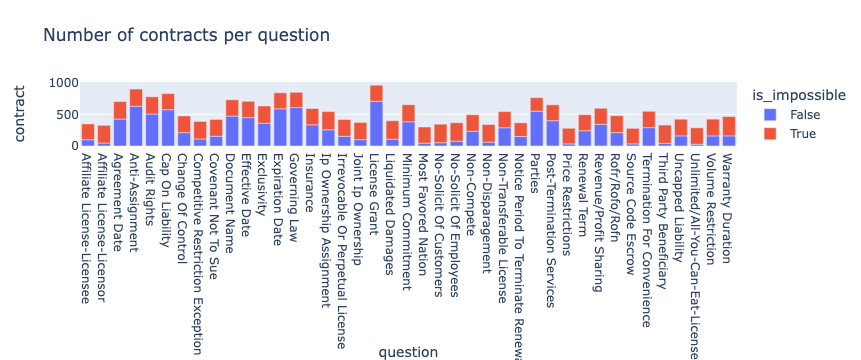

In [55]:
px.bar(df_g, x='question', y='contract', color='is_impossible', title='Number of contracts per question')

### Balanced dataset v2

Simple script to keep a frac of the is_impossible answers. Max

In [38]:
from collections import defaultdict
import torch
import plotly.express as px
from tqdm import tqdm
import numpy as np
import pandas as pd
def get_balanced_dataset_v2(dataset, features, keep_frac=1, return_positives_dict=False, q_post_process=None):
    """
    returns a new dataset, where all positive are kept and keep_frac fraction of negative examples are kept.
    """
    # assert positive frac
    assert keep_frac > 0, "keep_frac must be greater than 0"

    neg_ids = defaultdict(list)
    q_count = defaultdict(int)
    keep_idx = []
    for idx, ele in tqdm(enumerate(dataset), desc='Finding negative examples', total=len(dataset)):
        # Get feature id
        _,_,_,_,_,_,_,_,feature_index = ele
        feat = features[feature_index.item()]
        contract,question = feat.qas_id.split('__')

        if q_post_process=='train_separate_questions':
            question='_'.join(question.split('_')[:-1])

        if not feat.is_impossible:
            q_count[question] += 1
            keep_idx.append(idx)
    
        else:
            neg_ids[question].append(idx)

    # Get balanced dataset
    for k,v in q_count.items():
        if v>=1:
            keep_idx.extend(np.random.choice(neg_ids[k], size=min(int(v*keep_frac),len(neg_ids[k])), replace=False).tolist())
    assert len(keep_idx) == len(set(keep_idx))
    subset_dataset = torch.utils.data.Subset(dataset, keep_idx)
    
    if return_positives_dict:
        return subset_dataset, q_count
    return subset_dataset

In [2]:
dataset_new=torch.load('../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_False_doc-stride_256_dataset-type_train_train-file-version_train_non_sep_dataset')

In [3]:
features_new=torch.load('../cuad_training/cuad_lightning/out/dataset-name_CUAD_model-type_roberta_only-first-ans_False_doc-stride_256_dataset-type_train_train-file-version_train_non_sep_features')

In [39]:
print("Original dataset size:", len(dataset_new))
dataset_new_balanced, q_count = get_balanced_dataset_v2(dataset_new, features_new, return_positives_dict=True, keep_frac=2)
print("Balanced dataset size:", len(dataset_new_balanced))

Original dataset size: 703959


Finding negative examples: 100%|██████████| 703959/703959 [00:40<00:00, 17442.00it/s]


Balanced dataset size: 32541


In [40]:
features_new2=[]
for ele in tqdm(dataset_new_balanced):
    input_ids,attention_masks,token_type_ids,start_positions,end_positions,cls_index,p_mask,is_impossible,feature_index = ele
    features_new2.append(features_new[feature_index.item()])

100%|██████████| 32541/32541 [00:04<00:00, 7189.01it/s] 


In [41]:
data = []
for feature in tqdm(features_new2):
    contract,question = feature.qas_id.split('__')
    data.append([contract, question, feature.is_impossible])

100%|██████████| 32541/32541 [00:00<00:00, 375875.67it/s]


In [42]:
df = pd.DataFrame(data, columns=['contract', 'question','is_impossible'])

In [43]:
df_g = df.groupby(['question','is_impossible']).count()
df_g = df_g.reset_index()
df_g.head(5)

,question,is_impossible,contract
0,Affiliate License-Licensee,False,99
1,Affiliate License-Licensee,True,198
2,Affiliate License-Licensor,False,47
3,Affiliate License-Licensor,True,94
4,Agreement Date,False,427


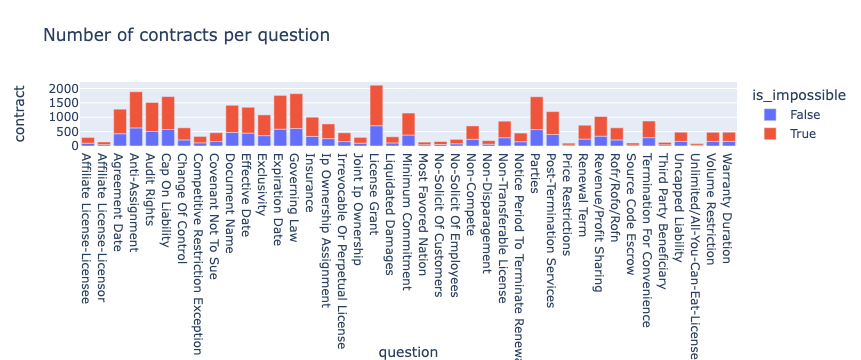

In [44]:
px.bar(df_g, x='question', y='contract', color='is_impossible', title='Number of contracts per question')